# Машинное обучение, DS-поток
## Задание 1.2


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Теоретические задачи необходимо оформить в LaTeX/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.
* При решении без доказательства можно пользоваться любыми теоретическими свойствами, которые были на лекциях или семинарах.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

**Баллы за задание**
* Задача 1 &mdash; 4 балла
* Задача 2 &mdash; 3 балла
* Задача 3 &mdash; 3 балла
* Задача 4 &mdash; 7 баллов
* Задача 5 &mdash; 3 балла

## Задача 1.

В случае задачи классификации рассматривается вероятностное предсказание, и критерий информативности имеет вид
$$H(X) = \min_{\stackrel{p_1, ..., p_K \in [0, 1]}{p_1+...+p_K=1}} \dfrac{1}{n} \sum_{i=1}^n L\left(Y_i, \{p_k\}\right).$$
Выведите и упростите критерии информативности, найдите оптимальные оценки вероятностей в листах для следующих функций потерь:
* $L(y, \{p_k\}) = \sum_{k=1}^K \left(p_k-I\{y=k\}\right)^2$;
* $L(y, \{p_k\}) = -\sum_{k=1}^K I\{ y=k\}\log p_k$.

## Задача 2.

Запишите оценку сложности построения одного решающего дерева в зависимости от размера обучающей выборки $n$, числа признаков $d$, максимальной глубины дерева $D$. В качестве правил используются пороговые функции $I\{x_j>t\}$. При выборе правил в каждой вершине перебираются все признаки, а в качестве порогов рассматриваются величины $t$, равные значениям этого признака на объектах, попавших в текущую вершину. Для простоты, считайте сложность вычисления критерия информативности по уже построенному множеству объектов константной.

## Задача 3.

Пусть обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$ такова, что
* объекты $X_1, ..., X_n$ одномерны и имеют распределение $\mathcal{N}(0, \sigma^2)$;
* отклик получается по правилу $Y_i = X_i^2 + \varepsilon_i$, где $\varepsilon_i$ независимы, имеют нулевое среднее и не зависят от $X_i$. 

Пусть также для объекта $X$ отклик $Y$ получен по аналогичному правилу, причем $X$ и $Y$ не зависят от обучающей выборки.

Для МНК-модели $\widehat{y}(x) = \widehat{\theta} x$ выпишите bias-variance разложение. Компоненту, отвечающую за разброс, разрешается не доводить до конца, как это было сделано на семинаре.

## Задача 4.

В этой задаче вам предлагается исследовать зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмём датасет `california_housing` из библиотеки `sklearn` о стоимости недвижимости в различных округах Калифорнии. Этот датасет состоит из 20640 записей и содержит следующие признаки для каждого округа: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`. `HouseAge` и `Population` - целочисленные признаки. Остальные признаки - вещественные.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer
from tqdm import tqdm

sns.set(style='whitegrid', font_scale=1.2, palette='Set2')

In [8]:
housing = fetch_california_housing()
X, y = housing.data, housing.target
X.shape

(20640, 8)

Разбейте данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

Посмотрите, как изменяется качество леса в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25). Когда варьируете один из параметров, в качестве другого берите значение по умолчанию.

Попробуйте получить зависимость от количества деревьев, обучив лишь один случайный лес. В этом вам поможет аттрибут `_estimators` у обученной модели.

In [7]:
def cum_metric(model, metric, x_test, y_test):
    ''' 
    Считает значение метрики в зависимости от количества деревьев в модели
    
    Мы не обучаем много лесов с разным кол-вом деревьев, 
    а смотрим на один обученный лес. Предсказание леса из k деревьев — 
    усредненное предсказание первых k деревьев из нашего леса.

    Параметры.
    1) model — модель случайного леса,
    2) metric — вычисляемая метрика,
    3) x_test — данные тестовой выборки,
    4) y_test — метки тестовой выборки.
    '''
    
    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) \
              / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis]
    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)

100%|██████████| 100/100 [12:27<00:00,  7.47s/it]


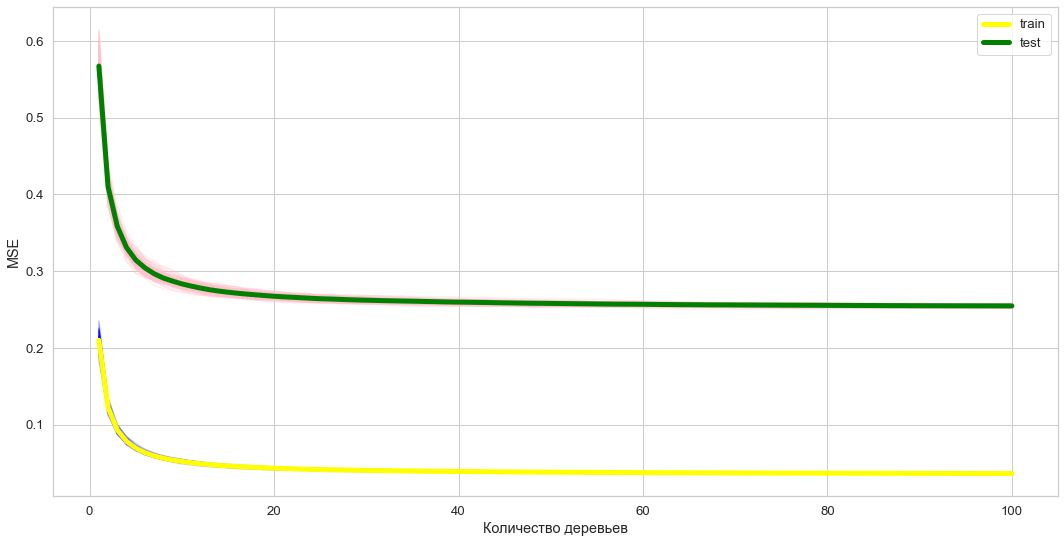

Wall time: 12min 27s


In [58]:
%%time

n_iterations = 100
n_estimators = 100
scores_train = np.zeros((n_iterations, n_estimators))
scores_test = np.zeros((n_iterations, n_estimators))
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

for i in tqdm(range(n_iterations)):
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, y_train)
    scores_train[i] = cum_metric(rf, mean_squared_error, X_train, y_train)
    scores_test[i] = cum_metric(rf, mean_squared_error, X_test, y_test)
    plt.plot(estrimator_range, scores_train[i], color='blue', alpha=0.15)
    plt.plot(estrimator_range, scores_test[i], color='pink', alpha=0.25)

plt.plot(estrimator_range, scores_train.mean(axis=0), 
         lw=5, color='yellow', label='train')
plt.plot(estrimator_range, scores_test.mean(axis=0), 
         lw=5, color='green', label='test')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.legend()
plt.show()

100%|██████████| 50/50 [1:44:51<00:00, 125.82s/it]


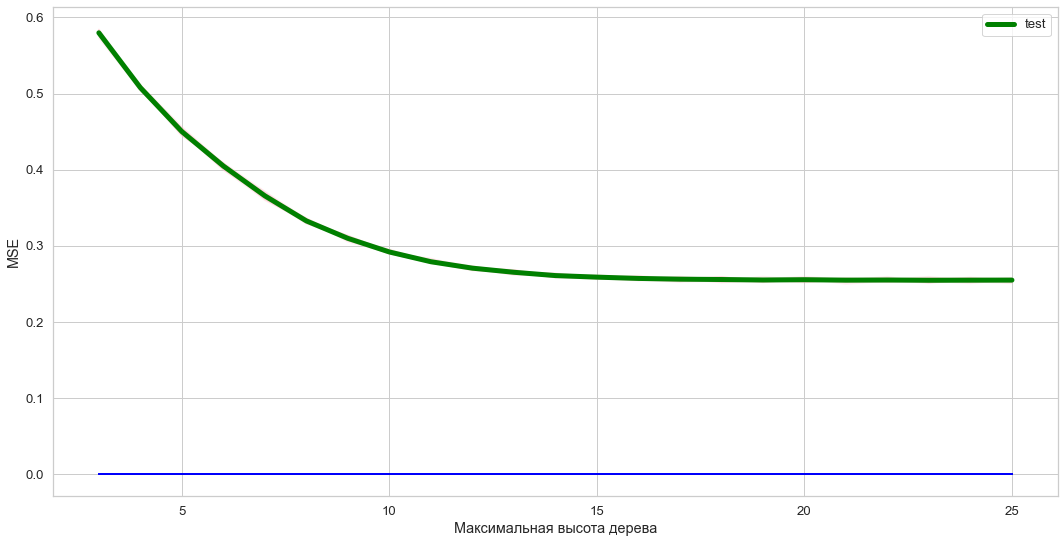

Wall time: 1h 44min 51s


In [59]:
%%time

n_iterations = 50
min_depth = 3
max_depth = 25
n_depths = max_depth - min_depth + 1
depth = np.linspace(min_depth, max_depth, n_depths, dtype=int)
scores_train = np.zeros((n_iterations, n_depths))
scores_test = np.zeros((n_iterations, n_depths))

plt.figure(figsize=(18, 9))

for i in tqdm(range(n_iterations)):
    for h in depth:
        rf = RandomForestRegressor(max_depth=h).fit(X_train, y_train)
        y_pred_train = rf.predict(X_train)
        y_pred_test = rf.predict(X_test)
        scores_test[i][h - min_depth] = mean_squared_error(y_test, y_pred_test)
    plt.plot(depth, scores_test[i], color='pink', alpha=0.25)

plt.plot(depth, scores_test.mean(axis=0), lw=5, color='green', label='test')
plt.xlabel('Максимальная высота дерева'), plt.ylabel('MSE')
plt.legend()
plt.show()

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для случайного леса? Поясните свой ответ, опираясь на своё знание статистики.

**Ответ:** С ростом количества деревьев метрика почти монотонно убывает как на трейне, так и на тесте. Однако после какого-то момента метрика начинает убывать очень слабо, поэтому стоит зафиксировать значение, после которого метрика убывает незначительно. Такое поведение в целом логично, так как *bias*- и *noize*-компоненты не меняются с ростом числа деревьев, а *variance*-компонента уменьшается, если деревья не сильно зависят друг от друга, поэтому и *mse*, являющееся суммой этих трех компонент (байес в квадрате), будет уменьшаться, если деревья не сильно зависят друг от друга. Также логично, что с ростом числа деревьев они все больше и больше коррелируют, поэтому улучшение метрики очень сильно замедляется.

С высотой же дерева на данных значениях получилась аналогичная картина, но возможно, что после определенных значений метрика начнет увеличиваться. Это связано с переобучением. Однако если сравнить это с переобучением дерева, то очевидно, что `RandomForest` переобучается намного меньше и намного позже (у обычного дерева мы наблюдали переобучение уже на глубине около 5, а тут наблюдается стагнирование метрики на глубине в районе 15). Это связано с тем, что при увеличении глубины дерева уменьшается байес и растет *variance*. У дерева маленький *bias* означает большой *variance*, а вот у леса мы можем взять маленький байес и получить хорошую итоговую метрику засчет того, что *variance*-компонента растет слабо, если деревья почти независимые.

Обучите случайный лес с параметрами по умолчанию и выведите MSE на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты отличаются? Какие источники случайности есть при построении случайного леса и какие из них реализуются в данном случае?

In [26]:
n_iters = 3
for i in range(n_iters):
    rf = RandomForestRegressor().fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE на тестовой выборке: {mse}')

MSE на тестовой выборке: 0.25250572695256995
MSE на тестовой выборке: 0.254602282304048
MSE на тестовой выборке: 0.25450610964872566


**Ответ:** метрики не очень сильно различаются, но различие заметно. Это связано с тем, что лес строится случайно (как минимум случайность заключена в бутстрепной выборке, еще, если параметр `max_features` не равен числу признаков, то признаки тоже выбираются случайно).

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

In [27]:
tree_gridsearch = GridSearchCV(
    estimator=RandomForestRegressor(random_state=666),
    param_grid={
        'max_depth': [3, 5, 10, 25, None], 
        'n_estimators': [5, 10, 25, 50],
    }, verbose=2
)

In [28]:
tree_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................max_depth=3, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=3, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=25; total time=   0.2s
[CV] END .......................max_depth=3, n_

GridSearchCV(estimator=RandomForestRegressor(random_state=666),
             param_grid={'max_depth': [3, 5, 10, 25, None],
                         'n_estimators': [5, 10, 25, 50]},
             verbose=2)

Выведите найденные оптимальные параметры.

In [29]:
tree_gridsearch.best_params_

{'max_depth': 25, 'n_estimators': 50}

Зафиксируем эти оптимальные значения параметров и в дальнейшим будем их использовать.

In [30]:
max_depth = 25
n_estimators = 50

Оценим качество предсказаний обученного решающего леса.

In [31]:
print('train MSE {:.4f}'.format(
    mean_squared_error(y_train, tree_gridsearch.best_estimator_.predict(X_train))
))
print('test MSE {:.4f}'.format(
    mean_squared_error(y_test, tree_gridsearch.best_estimator_.predict(X_test))
))

train MSE 0.0375
test MSE 0.2572


Исследуйте зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

Постройте также график зависимости метрики mse на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

100%|██████████| 50/50 [31:12<00:00, 37.44s/it]


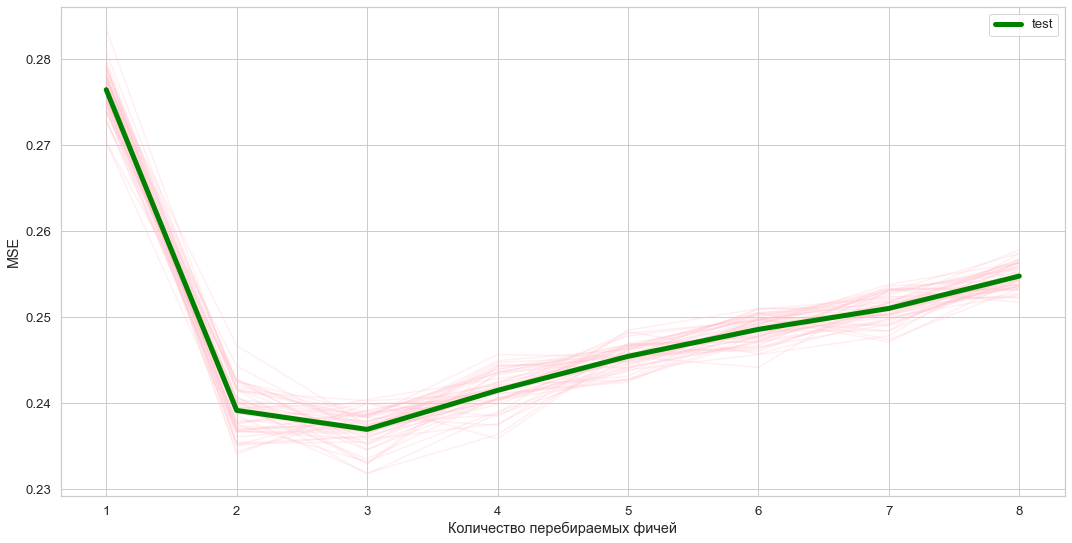

Wall time: 31min 12s


In [63]:
%%time

n_iterations = 50
d = 8
scores_train = np.zeros((n_iterations, d))
scores_test = np.zeros((n_iterations, d))

plt.figure(figsize=(18, 9))

for i in tqdm(range(n_iterations)):
    for n_features in range(1, d + 1):
        rf = RandomForestRegressor(max_features=n_features).fit(X_train, y_train)
        y_pred_train = rf.predict(X_train)
        y_pred_test = rf.predict(X_test)
        scores_test[i][n_features - 1] = mean_squared_error(y_test, y_pred_test)
    plt.plot(np.arange(d) + 1, scores_test[i], color='pink', alpha=0.25)

plt.plot(np.arange(d) + 1, scores_test.mean(axis=0), lw=5, color='green', label='test')
plt.xlabel('Количество перебираемых фичей'), plt.ylabel('MSE')
plt.legend()
plt.show()

Почему график получился таким? Как зависит разнообразие деревьев от величины `n_features`?

**Ответ:** с одной стороны, нам невыгодно брать мало перебираемых признаков, так как с высокой вероятностью мы просто не будем оптимально строить дерево, поэтому у нас будет расти *bias*. С другой стороны, нам невыгодно брать много перебираемых признаков, так как тогда деревья становятся сильнее зависимыми, откуда растет *variance*. Тогда следует брать среднее количество перебираемых фичей. В нашем случае золотой серединой для `RandomForest` стали 3 перебираемых фичи.

Проведите эксперимент, в котором выясните, как изменится качество регрессии, если набор признаков, по которым происходит разбиение в каждой вершине определяется не заново в каждой вершине, а задан заранее для всего дерева. То есть перед каждым построением дерева выбирается новый набор признаков, который будет рассматриваться при построении всех разбиений в этом дереве.

Для реализации данного эксперимента используйте класс беггинг-модели `sklearn.ensemble.BaggingRegressor`, у которого используйте следующие поля:
* `base_estimator` — базовая модель, используйте `sklearn.tree.DecisionTreeRegressor`;
* `max_features` — количество признаков для каждой базовой модели;
* `n_estimators` — количество базовых моделей.

Постройте графики `mse` на обучающей и на валидационной выборке в зависимости от числа рассматриваемых признаков в дереве.

Найдем оптимальные параметры, зафиксируем параметр `n_estimators` и, варьируя параметр `max_features`, построим график зависимости метрики от варьируемого параметра. 

In [41]:
tree_gridsearch = GridSearchCV(
    estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=666),
    param_grid={
        'max_features': np.arange(d, dtype=int) + 1, 
        'n_estimators': [5, 10, 25, 50],
    }, verbose=2
)

In [42]:
tree_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .....................max_features=1, n_estimators=5; total time=   0.0s
[CV] END .....................max_features=1, n_estimators=5; total time=   0.0s
[CV] END .....................max_features=1, n_estimators=5; total time=   0.0s
[CV] END .....................max_features=1, n_estimators=5; total time=   0.0s
[CV] END .....................max_features=1, n_estimators=5; total time=   0.0s
[CV] END ....................max_features=1, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=1, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....................max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....................max_features=1, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=1, n_estimators=25; total time=   0.2s
[CV] END ....................max_features=1, n_

[CV] END .....................max_features=6, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=6, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=6, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=6, n_estimators=5; total time=   0.1s
[CV] END ....................max_features=6, n_estimators=10; total time=   0.3s
[CV] END ....................max_features=6, n_estimators=10; total time=   0.3s
[CV] END ....................max_features=6, n_estimators=10; total time=   0.3s
[CV] END ....................max_features=6, n_estimators=10; total time=   0.3s
[CV] END ....................max_features=6, n_estimators=10; total time=   0.3s
[CV] END ....................max_features=6, n_estimators=25; total time=   1.0s
[CV] END ....................max_features=6, n_estimators=25; total time=   1.0s
[CV] END ....................max_features=6, n_estimators=25; total time=   1.0s
[CV] END ...................

GridSearchCV(estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                                        random_state=666),
             param_grid={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'n_estimators': [5, 10, 25, 50]},
             verbose=2)

In [43]:
tree_gridsearch.best_params_

{'max_features': 6, 'n_estimators': 50}

100%|██████████| 50/50 [15:50<00:00, 19.01s/it]


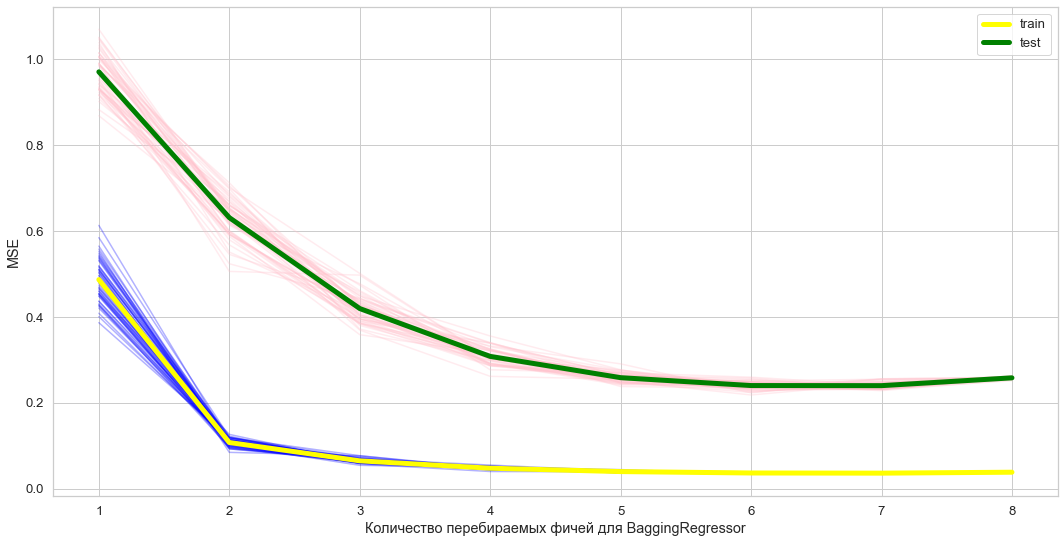

Wall time: 15min 50s


In [61]:
%%time

n_iterations = 50
d = 8
scores_train = np.zeros((n_iterations, d))
scores_test = np.zeros((n_iterations, d))

plt.figure(figsize=(18, 9))

for i in tqdm(range(n_iterations)):
    for n_features in range(1, d + 1):
        br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=n_features,
                             n_estimators=50).fit(X_train, y_train)
        y_pred_train = br.predict(X_train)
        y_pred_test = br.predict(X_test)
        scores_train[i][n_features - 1] = mean_squared_error(y_train, y_pred_train)
        scores_test[i][n_features - 1] = mean_squared_error(y_test, y_pred_test)
    plt.plot(np.arange(d) + 1, scores_train[i], color='blue', alpha=0.3)
    plt.plot(np.arange(d) + 1, scores_test[i], color='pink', alpha=0.3)

plt.plot(np.arange(d) + 1, scores_train.mean(axis=0), lw=5, color='yellow', label='train')
plt.plot(np.arange(d) + 1, scores_test.mean(axis=0), lw=5, color='green', label='test')
plt.xlabel('Количество перебираемых фичей для BaggingRegressor'), plt.ylabel('MSE')
plt.legend()
plt.show()

Сравните результаты обычного случайного леса с только что построенным лесом.

Сделайте выводы. Объясните, чем плох такой подход пострения случайного леса. Какое преимущество мы получаем, когда выбираем случайное подмножество признаков в каждой вершине в обычном случайном лесу?

**Вывод:** как мы видим из графиков и из подбора числа параметров, лучшее количество фичей в `BaggingRegressor` в нашем случае оказалось примерно 6-7, в отличие от `RandomForest`, у которого оптимальное количество фичей 3. Большее оптимальное количество перебираемых фичей связано с тем, что в `BaggingRegressor` перебираемые фичи фиксируются для всего дерева, то есть, дерево просто может не выбрать хорошие фичи и плохо обучиться, а в `RandomForest` перебираемые фичи фиксируются для каждой вершины в дереве, и если не выбрать хорошие фичи для вершины, то просто получится одно неоптимальное разделение, а, например, на следующем шаге мы можем выбрать оптимальные фичи, по которым получится хорошее разбиение. В результате недообучение происходит значительно реже. Если говорить о получившихся лучших метриках, то результаты примерно одинаковые: где-то 0.23-0.24.

Поясните разницу между следующими конструкциями:

`BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=n_features)`

`BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=n_features))`

Первая конструкция фиксирует число фичей в `BaggingRegressor` для каждого дерева, и этот набор фичей закреплен для всего дерева, а вторая конструкция фиксирует число фичей внутри дерева `DecisionTreeRegressor`, и этот набор фичей свой для каждой вершины дерева.

## Задача 5.

На лекции получена формула bias-variance разложения для беггинга. Проведите эксперимент, в котором выясните, насколько уменьшается разброс (variance-компонента) беггинг-модели на 100 базовых моделях по отношению к одной базовой модели. Используйте данные из предыдущей задачи. Рассмотрите беггинг на следующих базовых моделях:
* решающие деревья, можно использовать вариант случайного леса,
* ридж-регрессия.

Для решения задачи потребуется оценить корреляции предсказаний на тестовой выборке базовых моделей, входящих в состав беггинг-модели. Их можно получить с помощью поля `estimators_` у обученной беггинг-модели.

Насколько уменьшается разброс в каждом случае? Для каждого случая постройте также матрицу корреляций предсказаний базовых моделей и гистограмму по ним. Какую оценку коэффициента корреляции вы используете и почему?

* решающие деревья, можно использовать вариант случайного леса.

В качестве `base_estimator` будем использовать `DecisionTreeRegressor`, а не `RandomForestRegressor`, так как случайные леса будут намного больше коррелировать между собой, чем случайные деревья. Также поставим `max_features`= 3 в параметры `DecisionTreeRegressor` и не будем ограничивать глубину, чтобы деревья меньше коррелировали между собой.

In [136]:
%%time

n_estimators = 100
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

br = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=None, max_features=3),
                             n_estimators=n_estimators, verbose=2).fit(X_train, y_train)

predictions_by_estimators = np.array([est.predict(X_test) for est in br.estimators_])

df = pd.DataFrame(predictions_by_estimators.T) # собрали матрицу предсказаний отдельных деревьев
df 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Building estimator 15 of 100 for this parallel run (total 100)...
Building estimator 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.23579656818541853
Wall time: 3.53 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.164,1.284,1.117,1.218,1.342,1.629,1.917,1.117,2.042,1.360,...,2.321,1.905,1.085,1.598,1.629,1.351,1.238,1.135,1.284,1.419
1,0.750,0.659,0.553,0.553,1.779,1.108,1.195,0.806,0.598,0.557,...,0.557,0.557,0.721,0.520,0.721,0.971,0.700,0.688,0.553,0.919
2,0.754,0.788,0.950,1.160,0.788,0.936,1.086,0.955,0.620,0.536,...,1.057,0.935,1.058,0.555,1.052,1.003,0.938,0.555,0.858,0.555
3,1.743,2.239,1.777,1.785,1.865,1.743,1.545,1.829,1.873,1.909,...,1.343,1.759,1.617,1.863,1.779,1.500,1.875,1.743,1.780,1.704
4,0.690,0.778,0.550,3.333,0.724,0.655,1.148,1.316,0.632,0.640,...,1.010,0.750,0.778,0.758,0.853,0.711,0.932,1.216,1.450,0.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,3.319,3.319,2.396,3.119,2.175,2.218,1.838,4.471,2.821,4.471,...,4.471,3.542,3.426,3.119,2.396,3.292,1.630,2.273,3.344,1.676
5156,1.603,1.563,2.421,2.189,2.021,2.186,1.854,2.607,2.600,2.375,...,1.434,1.643,2.233,2.189,2.150,1.713,1.875,2.645,2.313,1.588
5157,1.905,1.310,1.659,1.701,2.365,2.448,1.592,1.818,1.791,2.855,...,1.553,1.274,1.622,4.176,1.893,3.244,1.701,1.661,2.855,3.500
5158,0.862,0.746,1.139,0.958,0.779,1.088,0.833,0.788,0.709,0.788,...,0.715,1.139,0.746,0.597,0.746,0.918,0.678,0.746,0.815,0.680


<Figure size 1296x648 with 0 Axes>

Построим матрицу попарных корреляций деревьев по матрице предсказаний.

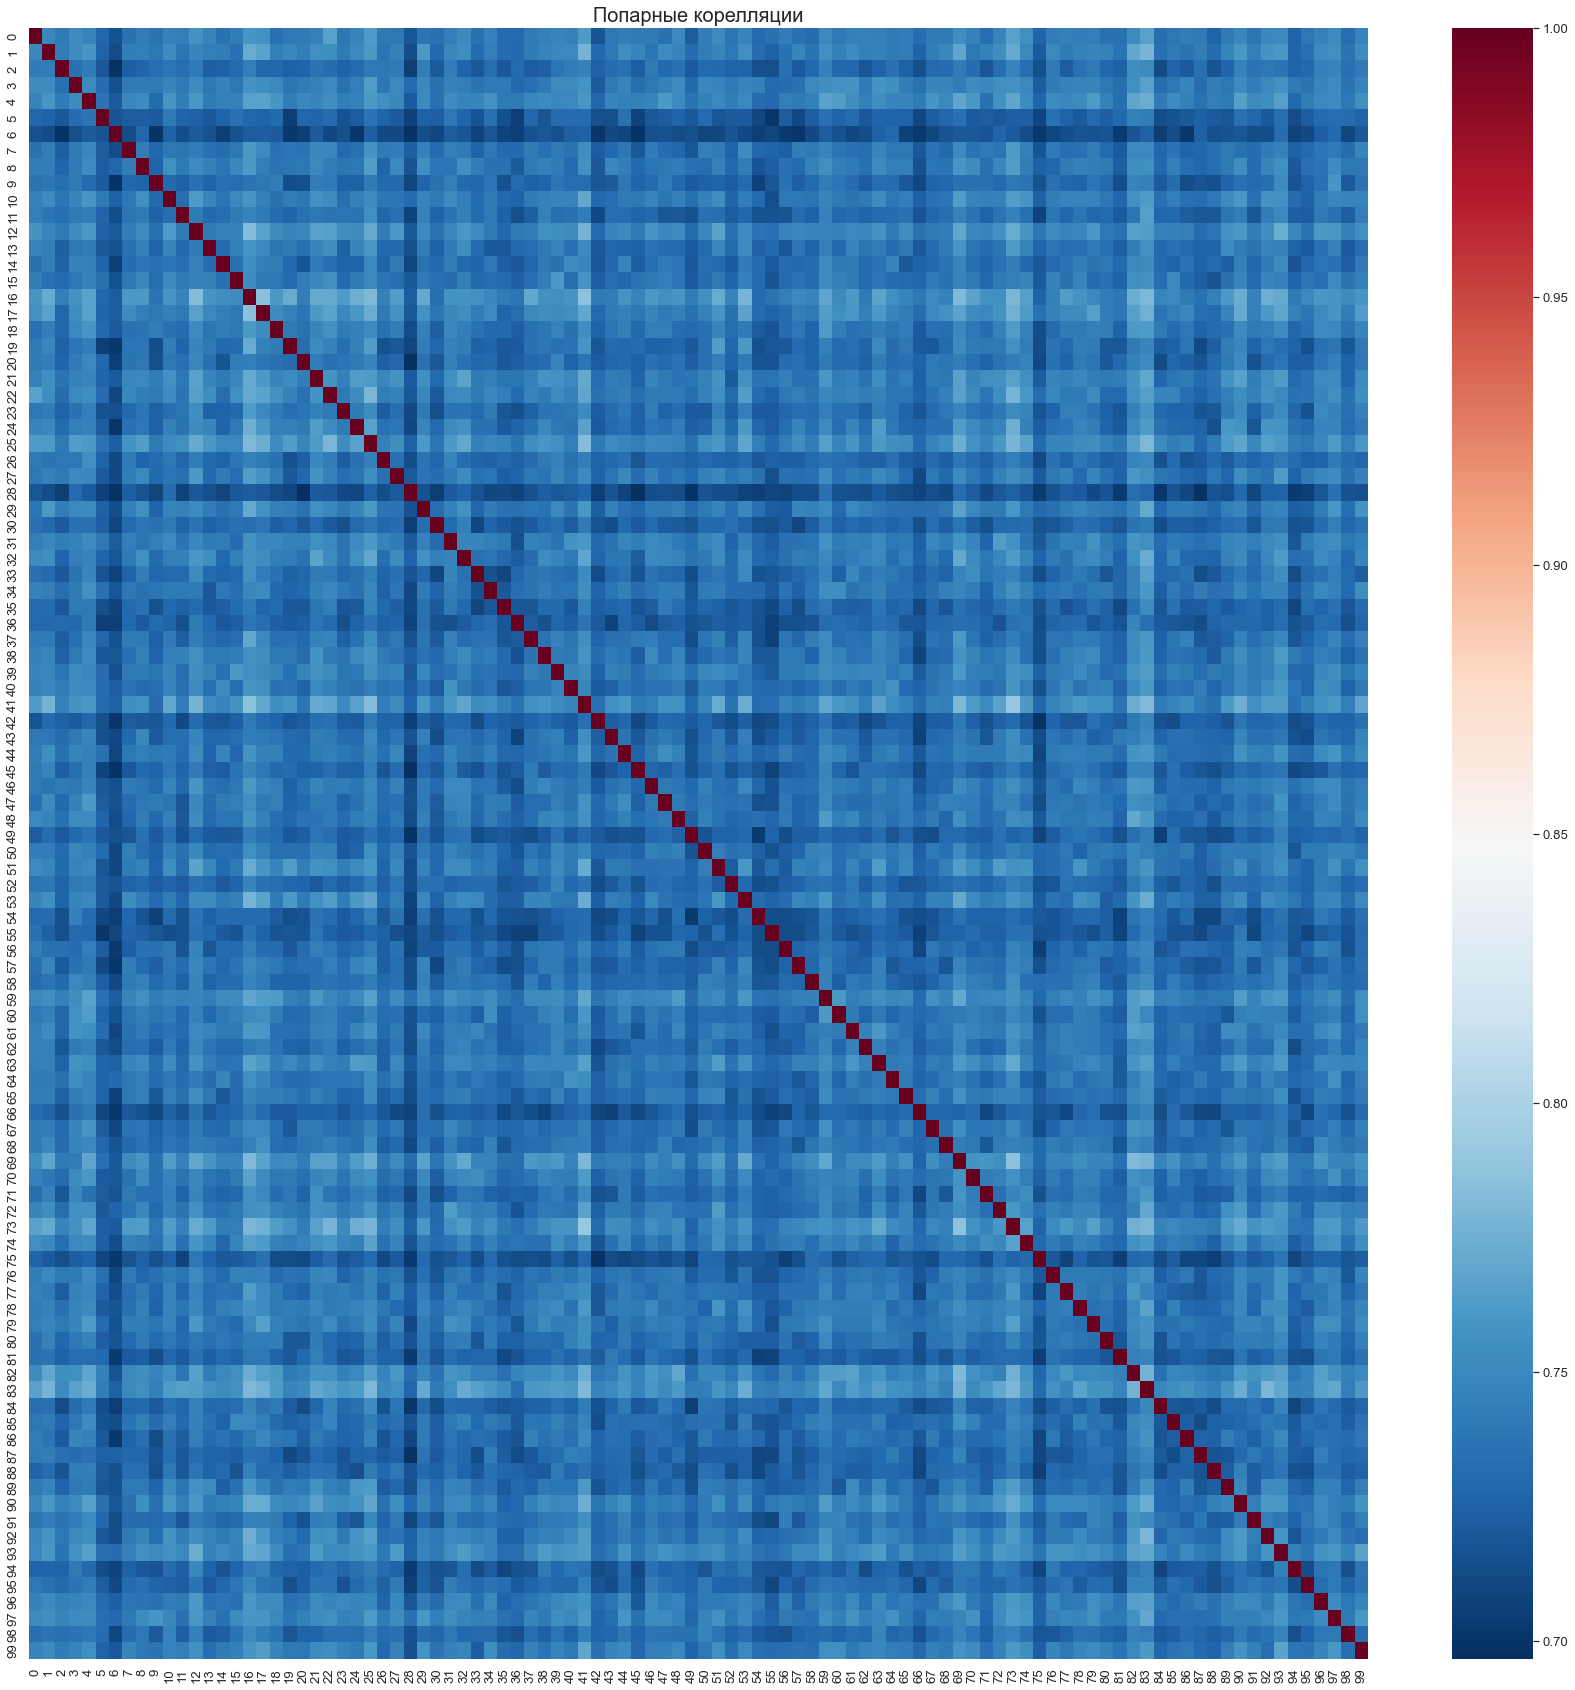

In [137]:
corr = df.corr(method='pearson')
plt.figure(figsize=(30, 30))
sns.heatmap(corr, cmap='RdBu_r')
plt.title('Попарные корелляции', fontsize=20)
plt.show()

Построим гистограммы по распределению предсказаний первых 5 наблюдений из теста (для каждого наблюдения отдельную гистограмму).

In [147]:
n_hists = 5
pred_slice = predictions_by_estimators[:, :n_hists].T
pred_slice.shape

(5, 100)

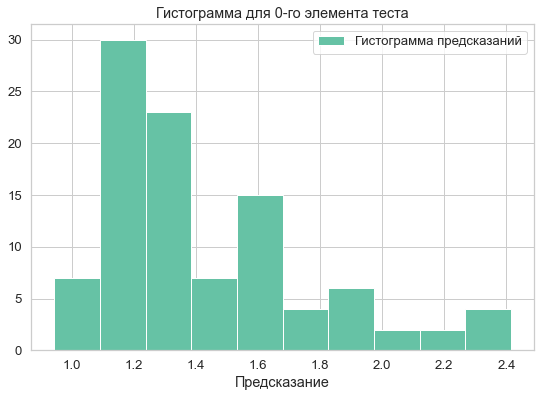

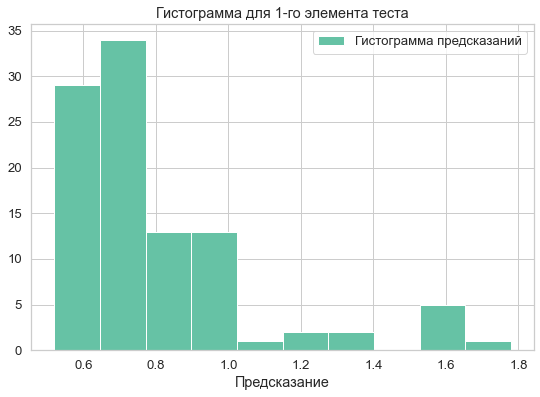

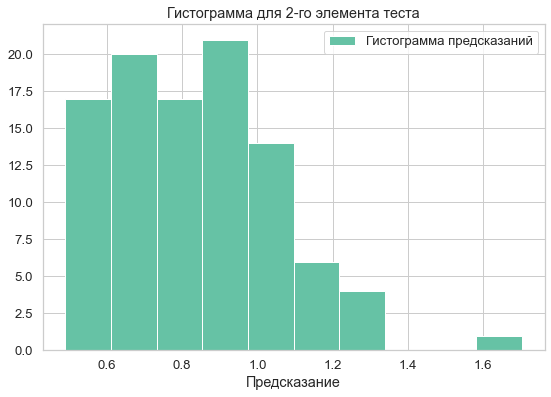

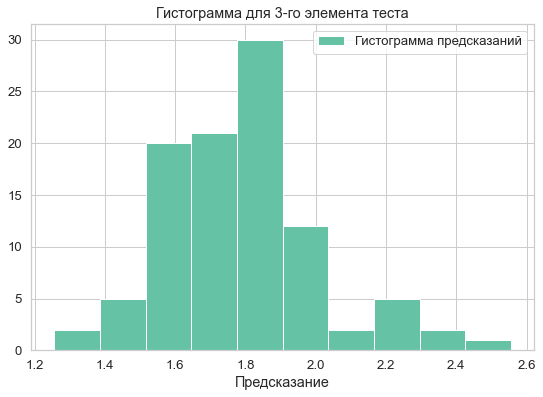

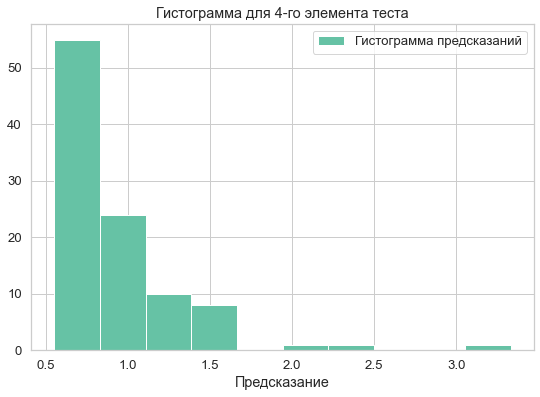

In [139]:
for i, pred in enumerate(pred_slice):
    plt.figure(figsize=(9, 6))
    plt.hist(pred, label=f'Гистограмма предсказаний')
    plt.xlabel('Предсказание')
    plt.title(f'Гистограмма для {i}-го элемента теста')
    plt.legend()
    plt.show()

Наконец, посчитаем матрицу попарных выборочных ковариаций. На самом деле, это и будет условная матрица ковариаций при условии выборок, попавшых в ковариирующие деревья. Поэтому, чтобы получить среднее значение условной ковариации, нам просто нужно взять среднее по матрице выборочных ковариаций (на самом деле, нам нужно убрать диагональ, так как мы смотрим ковариацию разных деревьев между собой; еще можно заметить, что матрица ковариаций симметричная, поэтому вычисляем среднее только по элементам выше главной диагонали). Также считаем среднее значение условной дисперсии по диагонали матрицы выборочных ковариаций. Далее вспомним формулу с лекции про *variance* бэггинга:
$$var(\widehat{y}) = \frac{1}{T}E(D(\widehat{y_1}(X)| X)) + \frac{T - 1}{T}E(cov(\widehat{y_1}(X), \widehat{y_2}(X)| X)),$$ где $T$ &mdash; это количество деревьев.
Заметим также, что *variance* одного дерева: $var(\widehat{y_1}) = E(D(\widehat{y_1}(X)| X)).$ Тогда нам осталость только рассчитать *variance* бэггинга по формуле выше и сравнить *variance* бэггинга и *variance* одного дерева.

In [140]:
cov = df.cov().to_numpy()
D = np.diagonal(cov)
cov_above_diag = []
for i in range(len(cov)):
    for j in range(i, len(cov)):
        cov_above_diag.append(cov[i, j])
        
mean_cov = np.mean(cov_above_diag)
mean_D = np.mean(D)
var_one = mean_D
var_hundred = 1 / n_estimators * mean_D + (n_estimators - 1) / n_estimators * mean_cov
print(f'дисперсия одной модели: {var_one}')
print(f'дисперсия ста моделей: {var_hundred}')

дисперсия одной модели: 1.307747460487619
дисперсия ста моделей: 0.9738960009435756


* ридж-регрессия.

Делаем все аналогично предыдущему случаю. Стоит только упомянуть, что для `Ridge` нужна нормализация, поэтому надо сначала нормализовать трейн и тест, а потом использовать модель.

In [141]:
%%time

n_estimators = 100
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

nm = Normalizer()
nm.fit(X_train)
X_train_normalized = nm.transform(X_train)
X_test_normalized = nm.transform(X_test)

br = BaggingRegressor(base_estimator=Ridge(),
                             n_estimators=n_estimators, verbose=2).fit(X_train, y_train)

score = mean_squared_error(y_test, br.predict(X_test))
print(score)

predictions_by_estimators = np.array([est.predict(X_test) for est in br.estimators_])

df = pd.DataFrame(predictions_by_estimators.T)
df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Building estimator 15 of 100 for this parallel run (total 100)...
Building estimator 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.970655,1.951531,1.950053,1.960957,1.960117,1.926703,1.947871,1.919274,1.683002,1.948024,...,1.875801,1.958618,1.955066,1.942809,1.946044,1.949235,1.941216,1.965293,1.938870,1.938802
1,1.289281,1.289554,1.282819,1.285419,1.299890,1.263277,1.288758,1.277345,1.202325,1.279232,...,1.271794,1.288152,1.289754,1.267579,1.297469,1.270195,1.268210,1.292749,1.282048,1.286923
2,0.728802,0.739962,0.709847,0.727097,0.741096,0.680572,0.717598,0.697805,0.780750,0.729407,...,0.747394,0.727617,0.720714,0.691516,0.735762,0.712976,0.683971,0.736659,0.726880,0.718981
3,2.043567,2.026183,2.039304,2.033454,2.042374,2.030656,2.033694,2.023713,1.980916,2.026075,...,2.021391,2.031507,2.047851,2.027733,2.027868,2.021257,2.035903,2.048644,2.021936,2.028500
4,1.301472,1.279621,1.311098,1.264719,1.274052,1.359045,1.311983,1.327353,1.397331,1.294019,...,1.322190,1.275395,1.304072,1.295222,1.329658,1.320572,1.321604,1.281230,1.267458,1.350934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,2.818120,2.790362,2.791875,2.806152,2.794699,2.753992,2.784204,2.759060,2.756458,2.782534,...,2.787766,2.798217,2.786617,2.798104,2.800804,2.804952,2.769175,2.800870,2.767864,2.767331
5156,1.856907,1.819781,1.836523,1.831806,1.833724,1.831676,1.831096,1.819149,1.889873,1.823776,...,1.843106,1.813856,1.839707,1.831162,1.846155,1.827231,1.827465,1.835421,1.808812,1.836985
5157,2.083159,2.053714,2.070115,2.085155,2.067793,2.052898,2.068130,2.057024,2.066406,2.045012,...,2.067384,2.069826,2.068722,2.067754,2.084119,2.053825,2.063679,2.062827,2.037240,2.052644
5158,0.947015,0.925519,0.932989,0.937238,0.947169,0.928906,0.932187,0.917910,0.911068,0.925807,...,0.915723,0.930480,0.945110,0.910394,0.928849,0.908856,0.936271,0.944186,0.922763,0.936352


<Figure size 1296x648 with 0 Axes>

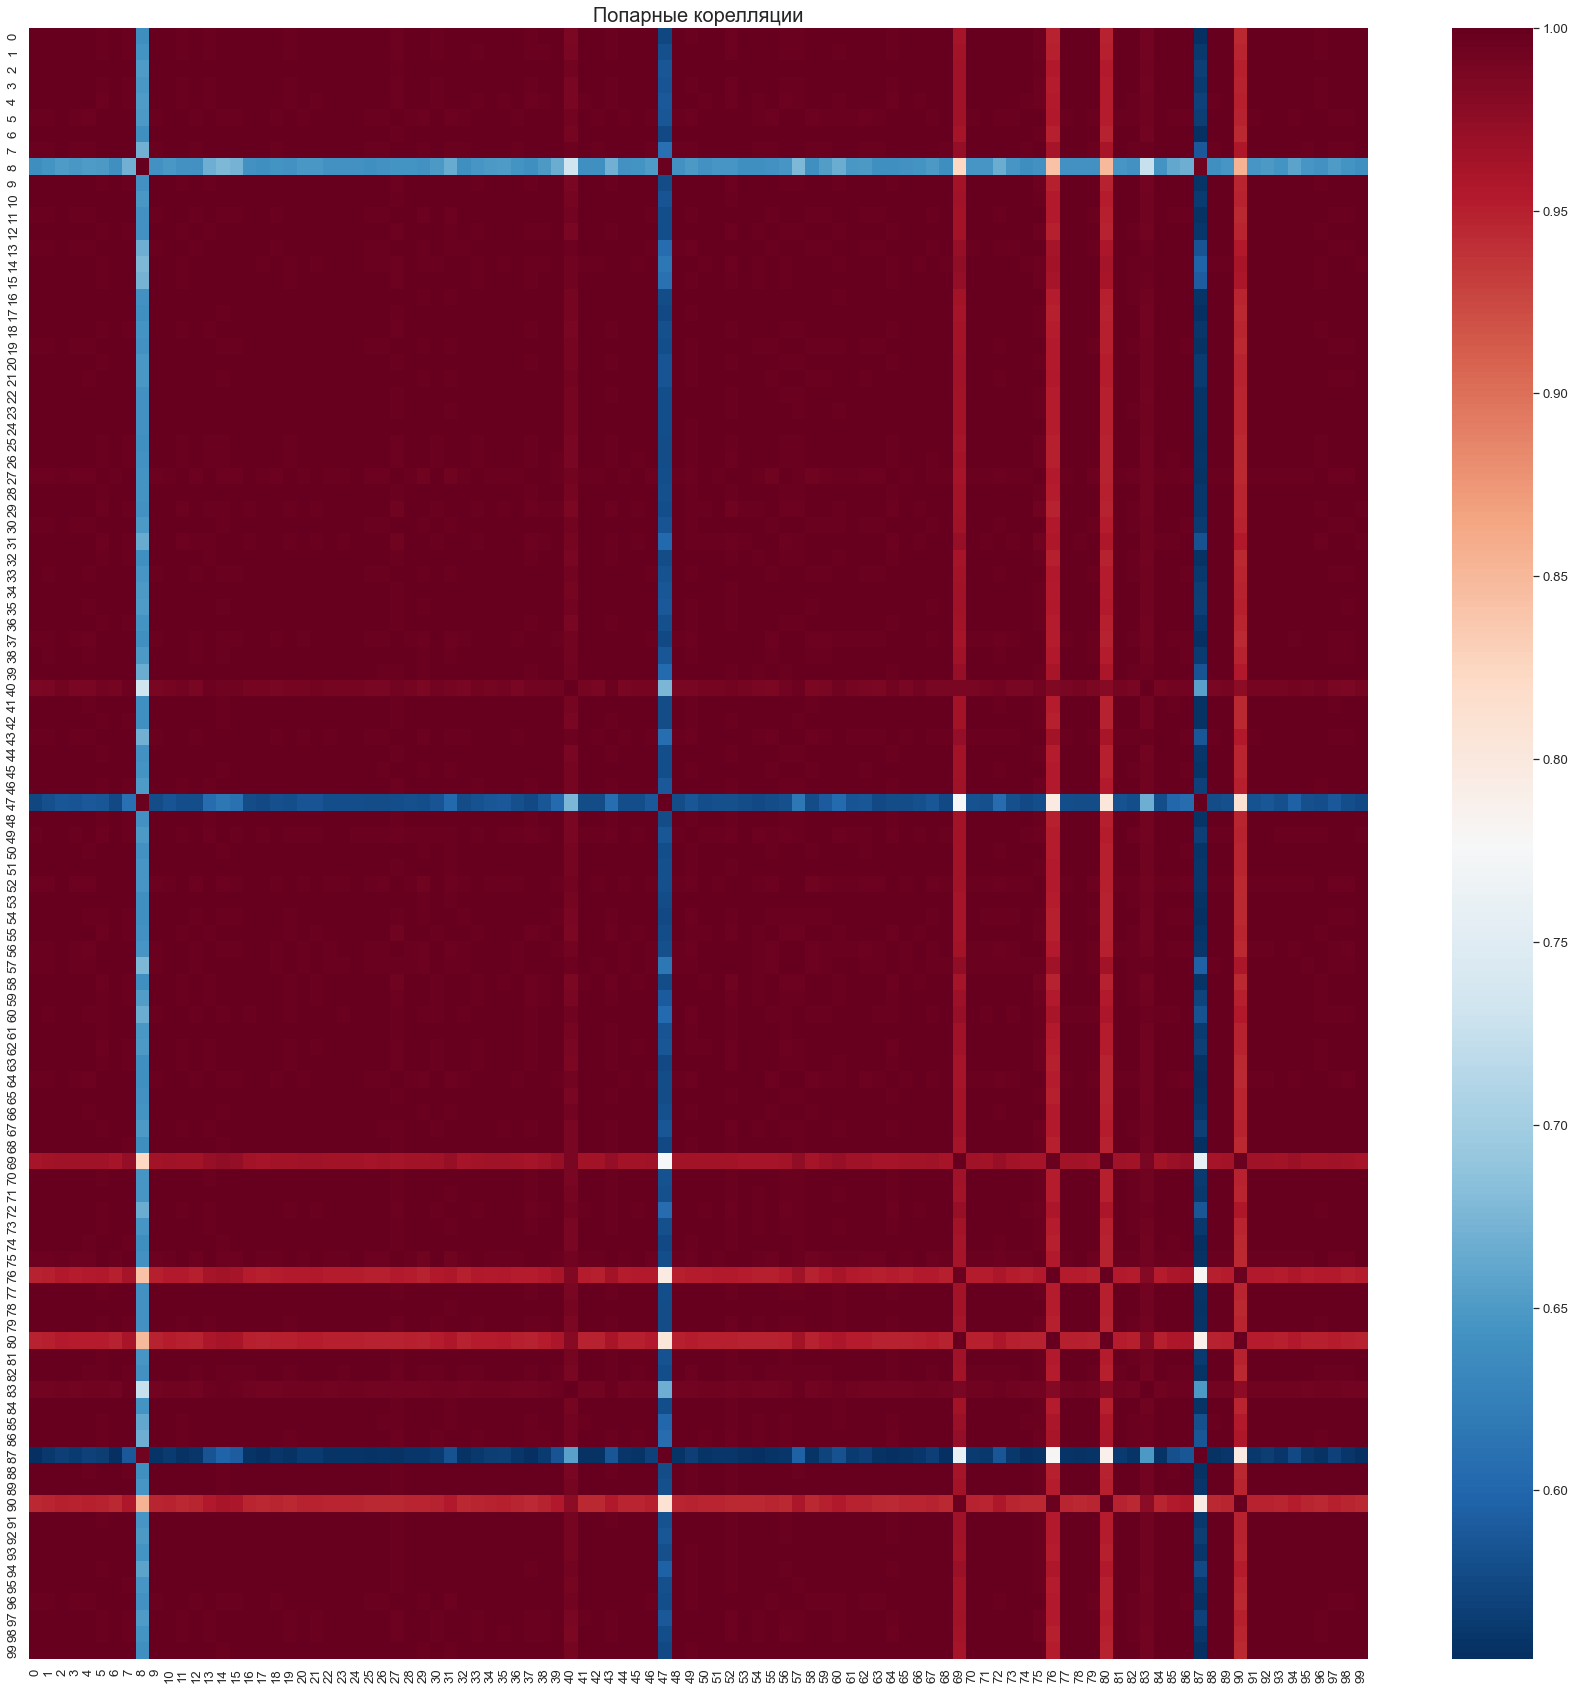

In [142]:
corr = df.corr(method='pearson')
plt.figure(figsize=(30, 30))
sns.heatmap(corr, cmap='RdBu_r')
plt.title('Попарные корелляции', fontsize=20)
plt.show()

In [143]:
n_hists = 5
pred_slice = predictions_by_estimators[:, :n_hists].T
pred_slice

array([[1.97065515, 1.95153115, 1.95005327, 1.96095688, 1.96011739,
        1.92670311, 1.94787129, 1.91927382, 1.68300207, 1.9480239 ,
        1.94406372, 1.94103838, 1.94928977, 1.93459705, 1.95367051,
        1.92870746, 1.94777816, 1.94663362, 1.95368586, 1.93945555,
        1.95093815, 1.91759227, 1.93504965, 1.93500372, 1.95080434,
        1.94178775, 1.94932767, 1.9313321 , 1.94987501, 1.94757931,
        1.94625509, 1.95196526, 1.95987244, 1.95124287, 1.94480839,
        1.94044699, 1.94965818, 1.94192751, 1.93635763, 1.938551  ,
        1.89882076, 1.95086581, 1.96238232, 1.94229553, 1.94201718,
        1.94360174, 1.94210593, 1.62103955, 1.95871161, 1.94092714,
        1.91517628, 1.95775984, 1.93279096, 1.94892646, 1.96906151,
        1.96093883, 1.94329912, 1.93822101, 1.95288632, 1.95563687,
        1.94515693, 1.94513508, 1.95256721, 1.95775339, 1.93201777,
        1.94227713, 1.9465674 , 1.95972922, 1.96884808, 1.88659584,
        1.95219682, 1.92666763, 1.95040669, 1.96

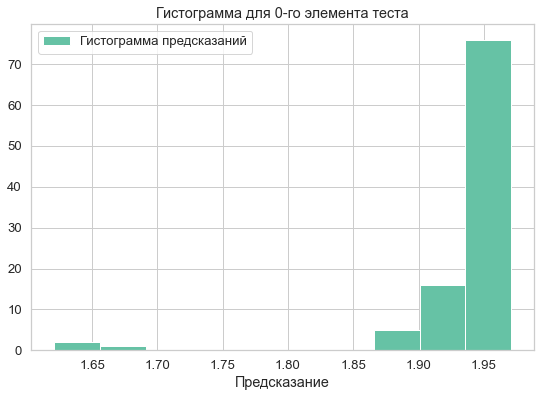

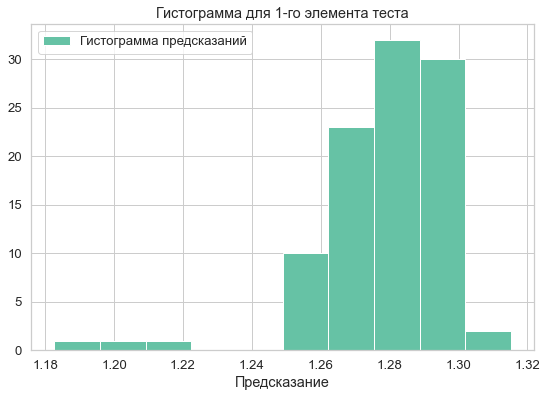

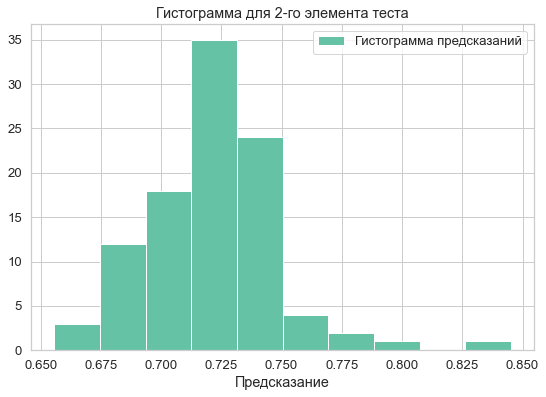

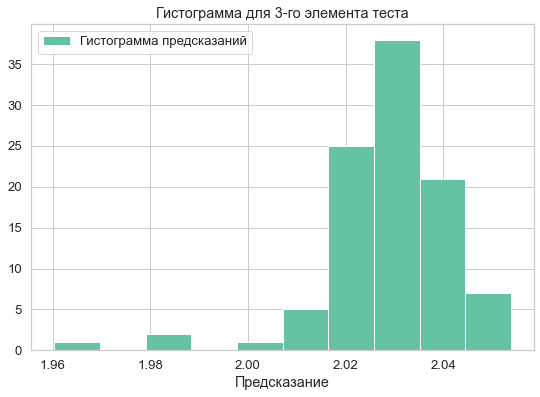

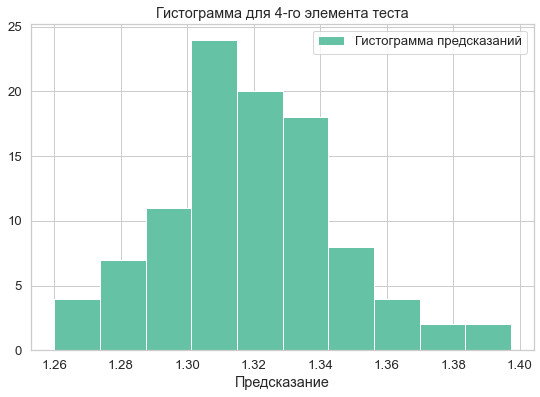

In [144]:
for i, pred in enumerate(pred_slice):
    plt.figure(figsize=(9, 6))
    plt.hist(pred, label=f'Гистограмма предсказаний')
    plt.xlabel('Предсказание')
    plt.title(f'Гистограмма для {i}-го элемента теста')
    plt.legend()
    plt.show()

In [145]:
cov = df.cov().to_numpy()
D = np.diagonal(cov)
cov_above_diag = []
for i in range(len(cov)):
    for j in range(i, len(cov)):
        cov_above_diag.append(cov[i, j])
        
mean_cov = np.mean(cov_above_diag)
mean_D = np.mean(D)
var_one = mean_D
var_hundred = 1 / n_estimators * mean_D + (n_estimators - 1) / n_estimators * mean_cov
print(f'variance одной модели: {var_one}')
print(f'variance ста моделей: {var_hundred}')

variance одной модели: 0.838980469656907
variance ста моделей: 0.7922144928416174


**Вывод:** мы построили матрицу корреляций отдельных деревьев и ридж-регрессий в бэггинг-модели, построили гистограмму распределения предсказаний на некоторых фичах из теста для отдельных деревьев и ридж-регрессий и посчитали *variance*-компоненту для одной модели и для бэггинга из ста моделей деревьев и ридж-регрессий. Касаемо корелляционной матрицы, в случае деревьев они коррелируют не слишком сильно (средняя корреляция деревьев в районе 0.75, что несколько больше, чем данные на лекции в районе 0.5, но имеем, что имеем), а в случае ридж-регрессии они зачастую коррелируют очень сильно (в основном корреляция больше 0.95 за редким исключением, что соотносится с данными с лекции). Это отражается и на гистограммах: у деревьев намного больше разброс относительно того, какое дать предсказание, чем у ридж-регрессий. Если говорить о различии между *variance*-компонентами для одной модели и для бэггинга из ста моделей, то в случае деревьев относительная разница составила весомые где-то 30%, а вот в случае ридж-регрессий относительная разница составила довольно незначительные где-то 5%, что говорит нам о том, что бэггинг может быть полезен для деревьев, а вот для ридж-регрессии бэггинг почти бесполезен, так как он не выполняет свою основную функцию, а именно, не уменьшает *variance*.